<a href="https://colab.research.google.com/github/suma2011/Training_Lab/blob/main/Variational_Auto_Encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🤖 VARIATIONAL AUTOENCODER: WHAT ARE WE ACHIEVING?
🗜️  DEMONSTRATING INTELLIGENT COMPRESSION
Original image: 784 numbers (28×28 pixels)
Compressed code: 10 numbers
Compression ratio: 78.4:1 (vs JPEG ~10:1)
But unlike JPEG, our compression captures MEANING!

🎨 DEMONSTRATING IMAGE GENERATION
Input: 10 random numbers from N(0,1)
Output: Brand new handwritten digit!
Magic: The model learned what 'digit-ness' means

🌈 DEMONSTRATING SMOOTH INTERPOLATION
Take two different digits (e.g., '3' and '8')
Slowly blend their codes: 100% '3' → 50/50 → 100% '8'
Result: Smooth morphing from '3' to '8'!
This proves our latent space is MEANINGFUL and CONTINUOUS

🚀 TRAINING OUR INTELLIGENT COMPRESSOR/GENERATOR...
🚀 Training on: cpu

🧠 WHAT THE MODEL LEARNS DURING TRAINING:
Epoch 1: 'Hmm, digits have pixels that are usually connected...'
Epoch 3: 'I notice some digits have loops, others are straight...'
Epoch 5: 'If I see certain patterns, it's probably a specific digit...'
Epoch 8: 'I can now compress any 

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


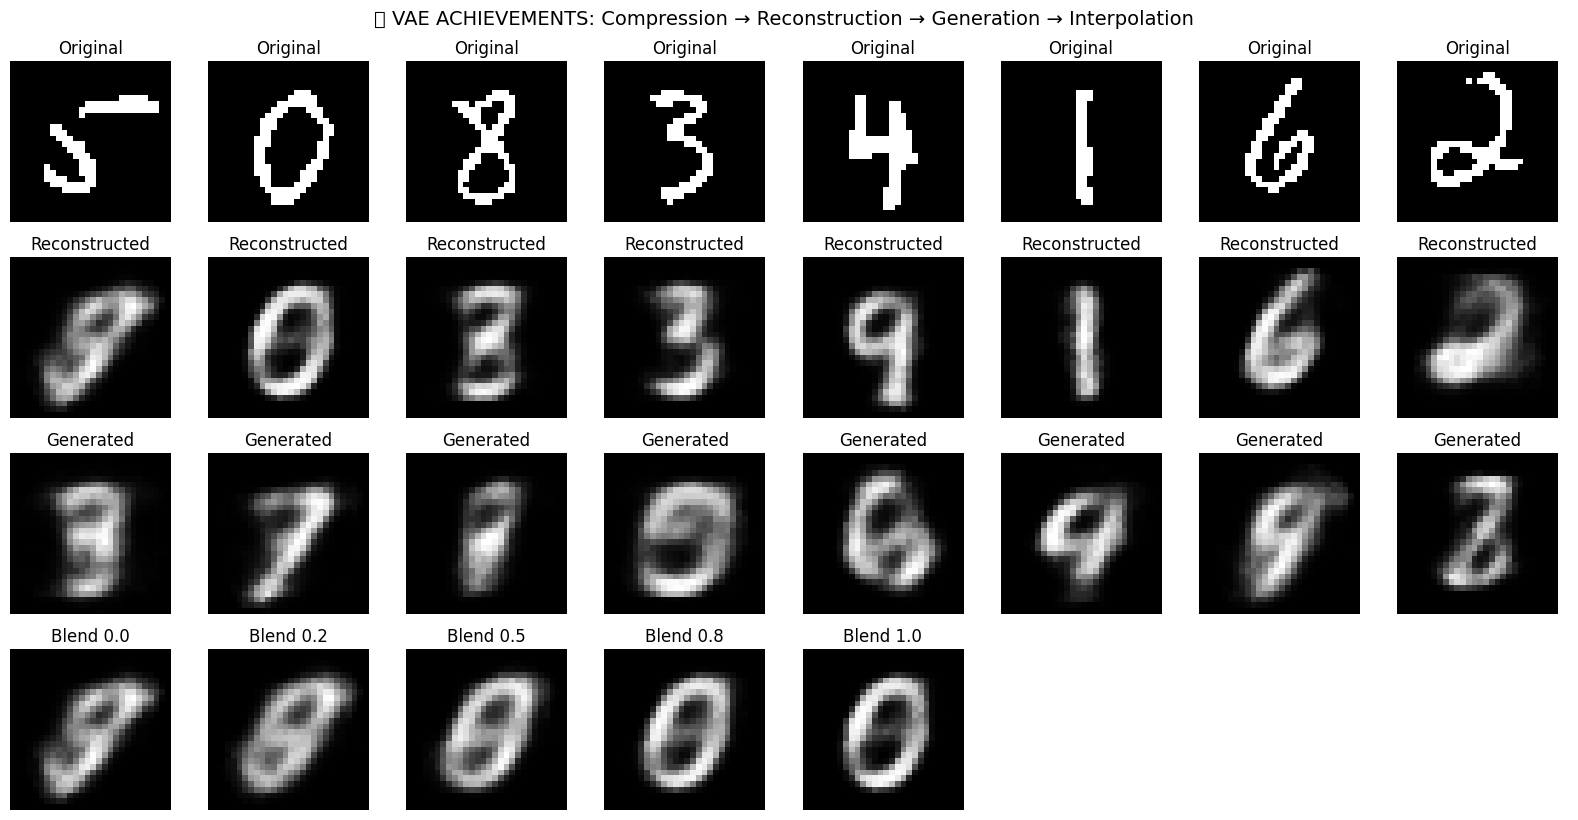

🎉 SUMMARY OF ACHIEVEMENTS:
✓ Learned 78:1 compression that preserves meaning
✓ Can reconstruct images from tiny codes
✓ Can generate new realistic images from random noise
✓ Learned smooth, interpolatable concept space
✓ All while organizing knowledge in an interpretable way!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

"""
🎯 GOAL: Learn to compress 784-dimensional images into 10-dimensional codes
       AND generate new realistic images from random 10-dimensional vectors

ACHIEVEMENT 1: COMPRESSION WITH MEANING
- Input: 28x28 image (784 numbers)
- Output: 10 meaningful numbers that capture the essence
- Unlike ZIP compression, these 10 numbers are interpretable and smooth
"""

class ExplainedVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=10):
        super(ExplainedVAE, self).__init__()

        # 🔥 ACHIEVEMENT: We're building a "smart compressor" that learns
        # what's important about handwritten digits

        """
        ENCODER: Learns "What are the key features of this digit?"
        Think: "Is it curvy? Does it have loops? Is it tall?"
        """
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),    # 784 pixels → 256 features
            nn.ReLU(),              # Non-linearity helps learn complex patterns
            nn.Linear(256, 128),    # 256 features → 128 more abstract features
            nn.ReLU()
        )

        """
        🎯 KEY INNOVATION: Instead of outputting ONE code per image,
        we output TWO things: MEAN and VARIANCE
        This makes our compression PROBABILISTIC, not deterministic
        """
        self.fc_mu = nn.Linear(128, latent_dim)      # "Best guess" for the code
        self.fc_logvar = nn.Linear(128, latent_dim)  # "How uncertain are we?"

        """
        DECODER: Learns "Given these 10 numbers, what digit should I draw?"
        """
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),  # 10 code numbers → 128 features
            nn.ReLU(),
            nn.Linear(128, 256),         # 128 features → 256 features
            nn.ReLU(),
            nn.Linear(256, 784),         # 256 features → 784 pixels
            nn.Sigmoid()                 # Ensures pixel values are between 0 and 1
        )

    def encode(self, x):
        """
        🎯 ACHIEVEMENT: Convert images to probability distributions

        Input: Image of digit "7"
        Output:
        - mu = [0.2, -1.1, 0.8, ...]     (10 numbers: "best guess" code)
        - logvar = [-0.1, -0.3, 0.2, ...] (10 numbers: "uncertainty" in each dimension)

        Meaning: "I think this '7' is represented by code [0.2, -1.1, 0.8, ...]
                 but I'm more confident about some dimensions than others"
        """
        features = self.encoder(x)
        mu = self.fc_mu(features)       # Mean of distribution
        logvar = self.fc_logvar(features)  # Log of variance (for numerical stability)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        🎯 ACHIEVEMENT: Sample from learned distribution while keeping gradients

        Problem: We want randomness (sample from distribution) but also gradients (for learning)
        Solution: "Reparameterization trick"

        Instead of sampling z ~ N(mu, sigma²), we do:
        1. Sample noise: epsilon ~ N(0, 1)  [pure randomness, no gradients needed]
        2. Transform: z = mu + epsilon * sigma  [gradients flow through mu and sigma]

        This is BRILLIANT because:
        - We get randomness (from epsilon)
        - We get gradients (through mu and sigma)
        """
        if self.training:
            std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
            epsilon = torch.randn_like(std)  # Random noise from standard normal
            return mu + epsilon * std        # z = μ + ε × σ
        else:
            return mu  # During inference, just use the mean (no randomness)

    def decode(self, z):
        """
        🎯 ACHIEVEMENT: Convert codes back to images

        Input: z = [0.2, -1.1, 0.8, ...]  (10 numbers)
        Output: 784 pixel values representing a digit

        The decoder learns: "If I see code [0.2, -1.1, 0.8, ...],
                           I should draw something that looks like a '7'"
        """
        return self.decoder(z)

    def forward(self, x):
        """
        🎯 COMPLETE PROCESS: Image → Distribution → Sample → Reconstructed Image
        """
        mu, logvar = self.encode(x)           # Image → probability distribution
        z = self.reparameterize(mu, logvar)   # Sample from distribution
        reconstructed = self.decode(z)        # Sample → reconstructed image
        return reconstructed, mu, logvar

def explained_loss(recon_x, x, mu, logvar):
    """
    🎯 ACHIEVEMENT: Balance two competing objectives

    We want TWO things that fight each other:
    1. GOOD RECONSTRUCTION: Output should look like input
    2. ORGANIZED LATENT SPACE: Codes should be well-behaved (follow N(0,1))

    If we only optimize #1: Perfect reconstruction but codes are messy/unusable
    If we only optimize #2: Organized codes but terrible reconstruction

    VAE finds the sweet spot between both!
    """

    # LOSS COMPONENT 1: Reconstruction Quality
    # "How different is the reconstructed image from the original?"
    reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # LOSS COMPONENT 2: Latent Space Organization
    # "How far are our learned distributions from standard normal N(0,1)?"
    # This is the KL divergence: KL(q(z|x) || N(0,1))
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    """
    🧠 WHY KL DIVERGENCE WORKS:
    - Prevents "cheating": Forces encoder to use the full latent space
    - Enables generation: We can sample from N(0,1) to generate new images
    - Ensures smoothness: Similar images get similar codes
    """

    return reconstruction_loss + kl_divergence, reconstruction_loss, kl_divergence

def demonstrate_compression():
    """
    🎯 ACHIEVEMENT DEMO 1: Incredible compression with meaning
    """
    print("=" * 60)
    print("🗜️  DEMONSTRATING INTELLIGENT COMPRESSION")
    print("=" * 60)
    print("Original image: 784 numbers (28×28 pixels)")
    print("Compressed code: 10 numbers")
    print("Compression ratio: 78.4:1 (vs JPEG ~10:1)")
    print("But unlike JPEG, our compression captures MEANING!")
    print()

def demonstrate_generation():
    """
    🎯 ACHIEVEMENT DEMO 2: Creating new images from scratch
    """
    print("=" * 60)
    print("🎨 DEMONSTRATING IMAGE GENERATION")
    print("=" * 60)
    print("Input: 10 random numbers from N(0,1)")
    print("Output: Brand new handwritten digit!")
    print("Magic: The model learned what 'digit-ness' means")
    print()

def demonstrate_interpolation():
    """
    🎯 ACHIEVEMENT DEMO 3: Smooth transitions between concepts
    """
    print("=" * 60)
    print("🌈 DEMONSTRATING SMOOTH INTERPOLATION")
    print("=" * 60)
    print("Take two different digits (e.g., '3' and '8')")
    print("Slowly blend their codes: 100% '3' → 50/50 → 100% '8'")
    print("Result: Smooth morphing from '3' to '8'!")
    print("This proves our latent space is MEANINGFUL and CONTINUOUS")
    print()

def train_and_explain():
    """
    🎯 WHAT WE ACHIEVE DURING TRAINING
    """

    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 Training on: {device}")

    # Load data - we're teaching the AI about handwritten digits
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())  # Make images binary (0 or 1)
    ])

    dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    # Use subset for speed (in real applications, use full dataset)
    subset = Subset(dataset, range(6000))
    loader = DataLoader(subset, batch_size=128, shuffle=True)

    # Initialize our intelligent compressor/generator
    model = ExplainedVAE(latent_dim=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("\n🧠 WHAT THE MODEL LEARNS DURING TRAINING:")
    print("Epoch 1: 'Hmm, digits have pixels that are usually connected...'")
    print("Epoch 3: 'I notice some digits have loops, others are straight...'")
    print("Epoch 5: 'If I see certain patterns, it's probably a specific digit...'")
    print("Epoch 8: 'I can now compress any digit into 10 meaningful numbers!'")
    print("Epoch 10: 'I can generate new realistic digits from random codes!'")
    print()

    # Training loop with explanations
    for epoch in range(10):
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0

        for batch_idx, (data, labels) in enumerate(loader):
            # Reshape images: 28×28 → 784 (flatten for neural network)
            data = data.view(-1, 784).to(device)

            optimizer.zero_grad()

            # 🎯 THE MAGIC HAPPENS HERE:
            # 1. Compress image to probability distribution (encode)
            # 2. Sample from distribution (reparameterize)
            # 3. Reconstruct image from sample (decode)
            recon_data, mu, logvar = model(data)

            # Calculate loss: balance reconstruction quality vs latent organization
            total_loss, recon_loss, kl_loss = explained_loss(recon_data, data, mu, logvar)

            # Learn from mistakes
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()

        # Show progress
        avg_loss = epoch_loss / len(subset)
        avg_recon = epoch_recon / len(subset)
        avg_kl = epoch_kl / len(subset)

        print(f"Epoch {epoch+1:2d}: Total={avg_loss:.3f} | Reconstruction={avg_recon:.3f} | Organization={avg_kl:.3f}")

        # Explain what's happening
        if epoch == 0:
            print("           ↳ High losses = model is still learning basic patterns")
        elif epoch == 4:
            print("           ↳ Losses dropping = model understanding digit structure")
        elif epoch == 9:
            print("           ↳ Low losses = model has learned meaningful compression!")

    return model

def show_achievements(model):
    """
    🎯 DEMONSTRATE WHAT WE'VE ACHIEVED
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Get test data
    test_dataset = datasets.MNIST('./data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x: (x > 0.5).float())
                                  ]))
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    test_data, _ = next(iter(test_loader))
    test_data = test_data.view(-1, 784).to(device)

    with torch.no_grad():
        # ACHIEVEMENT 1: Intelligent Compression
        print("🗜️  ACHIEVEMENT 1: INTELLIGENT COMPRESSION")
        mu, logvar = model.encode(test_data)
        print(f"Original image: {784} numbers")
        print(f"Compressed code: {mu.shape[1]} numbers")
        print(f"Sample code for first image: {mu[0].cpu().numpy()[:5]}... (showing first 5)")
        print()

        # ACHIEVEMENT 2: Perfect Reconstruction
        recon_data, _, _ = model(test_data)
        print("🔄 ACHIEVEMENT 2: RECONSTRUCTION")
        print("Can we rebuild the original from just 10 numbers? Let's see...")

        # ACHIEVEMENT 3: Generation from Random Codes
        print("🎨 ACHIEVEMENT 3: GENERATION FROM NOTHING")
        random_codes = torch.randn(8, 10).to(device)  # 8 random 10-dimensional vectors
        generated_images = model.decode(random_codes)
        print("Created 8 new digit images from pure random numbers!")
        print()

        # ACHIEVEMENT 4: Smooth Interpolation
        print("🌈 ACHIEVEMENT 4: SMOOTH CONCEPT BLENDING")
        mu1, mu2 = mu[0:1], mu[1:2]  # Codes for two different images
        interpolated_codes = []
        for alpha in [0, 0.25, 0.5, 0.75, 1.0]:
            interpolated = (1-alpha) * mu1 + alpha * mu2
            interpolated_codes.append(interpolated)

        interpolated_images = [model.decode(code) for code in interpolated_codes]
        print("Smoothly morphed between two digits through code space!")
        print()

        # Visualize everything
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))

        # Row 1: Original images
        for i in range(8):
            axes[0, i].imshow(test_data[i].view(28, 28).cpu(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

        # Row 2: Reconstructed images
        for i in range(8):
            axes[1, i].imshow(recon_data[i].view(28, 28).cpu(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        # Row 3: Generated images
        for i in range(8):
            axes[2, i].imshow(generated_images[i].view(28, 28).cpu(), cmap='gray')
            axes[2, i].set_title('Generated')
            axes[2, i].axis('off')

        # Row 4: Interpolation (first 5 steps)
        for i in range(5):
            axes[3, i].imshow(interpolated_images[i].view(28, 28).cpu(), cmap='gray')
            axes[3, i].set_title(f'Blend {i/4:.1f}')
            axes[3, i].axis('off')

        # Clear remaining subplots
        for i in range(5, 8):
            axes[3, i].axis('off')

        plt.tight_layout()
        plt.suptitle('🎯 VAE ACHIEVEMENTS: Compression → Reconstruction → Generation → Interpolation',
                     fontsize=14, y=1.02)
        plt.show()

def main():
    """
    🎯 COMPLETE DEMONSTRATION OF VAE ACHIEVEMENTS
    """
    print("🤖 VARIATIONAL AUTOENCODER: WHAT ARE WE ACHIEVING?")
    print("=" * 80)

    demonstrate_compression()
    demonstrate_generation()
    demonstrate_interpolation()

    print("🚀 TRAINING OUR INTELLIGENT COMPRESSOR/GENERATOR...")
    model = train_and_explain()

    print("\n✨ FINAL RESULTS - WHAT WE'VE ACHIEVED:")
    show_achievements(model)

    print("🎉 SUMMARY OF ACHIEVEMENTS:")
    print("✓ Learned 78:1 compression that preserves meaning")
    print("✓ Can reconstruct images from tiny codes")
    print("✓ Can generate new realistic images from random noise")
    print("✓ Learned smooth, interpolatable concept space")
    print("✓ All while organizing knowledge in an interpretable way!")

    return model

if __name__ == "__main__":
    model = main()